## LSTM Training
This notebook sets up a basic LSTM model for use in this project.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Toy Problem
Setting up a toy time series binary classification problem. Generating a dataloader that contains univariate time series that is either linear or log.

In [3]:
def generate_data(length):
    X_data = []
    y_data = []
    
    for i in range(5000):
        eps = np.random.rand(3)
        X_data.append(np.linspace(0+(eps[0]/10), 1+(eps[1]/10), length) * eps[2])
        y_data.append(1)
    
    for i in range(5000):
        eps = np.random.rand(3)
        X_data.append(np.geomspace(0.0000001+(eps[0]/10), 1+(eps[1]/10), length) * eps[2])
        y_data.append(0)
    
    tensor_x = torch.Tensor(X_data).to(device)
    tensor_y = torch.Tensor(y_data).to(device)
    
    return DataLoader(TensorDataset(tensor_x, tensor_y), batch_size=64, shuffle=True)

In [4]:
trainloader = generate_data(500)
example = next(iter(trainloader))

C:\Users\austi\AppData\Local\Temp\ipykernel_10232\2063342039.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  tensor_x = torch.Tensor(X_data).to(device)


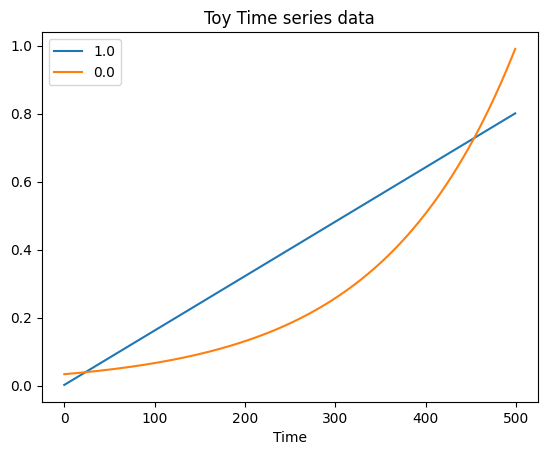

In [5]:
plt.title("Toy Time series data")
plt.plot(example[0][3].cpu(), label=example[1][3].item())
plt.plot(example[0][0].cpu(), label=example[1][0].item())
plt.xlabel("Time")
plt.legend()

### Hyperparameter Config

In [33]:
config = {
    'length': 500,
    'hidden_size': 64
}

### Transformer Model Architecture

In [38]:
class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.length = config['length']
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True, bidirectional=True)
        self.classification_head = nn.Linear(self.length*config['hidden_size']*2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.reshape_batch(x)
        z = self.lstm(x)[0]
        z = torch.flatten(z, 1)
        
        z = self.classification_head(z)
        return self.sigmoid(z).squeeze(1)
    
    def reshape_batch(self, data):
        return data.unsqueeze(2)

In [39]:
lstm = LSTM(config)
lstm(example[0])

tensor([0.4997, 0.5015, 0.5003, 0.4998, 0.4999, 0.5014, 0.5018, 0.5010, 0.5020,
        0.5014, 0.5014, 0.4992, 0.4995, 0.5018, 0.5009, 0.4999, 0.5019, 0.5013,
        0.4996, 0.5009, 0.5004, 0.5014, 0.5010, 0.5022, 0.5022, 0.5017, 0.4997,
        0.5009, 0.5012, 0.5007, 0.5006, 0.5004, 0.4999, 0.5014, 0.5015, 0.4997,
        0.5006, 0.5009, 0.5017, 0.5012, 0.5002, 0.5004, 0.5009, 0.5018, 0.4995,
        0.5008, 0.5005, 0.5013, 0.5007, 0.5016, 0.4997, 0.5014, 0.4996, 0.4999,
        0.5007, 0.5010, 0.4998, 0.5017, 0.4997, 0.5014, 0.5020, 0.5021, 0.5019,
        0.4996], grad_fn=<SqueezeBackward1>)

### Training Loop

In [41]:
objective = nn.BCELoss()

lstm = LSTM(config).to(device)

lr = 1e-4
n_epochs = 10
optim = torch.optim.Adam(lstm.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(trainloader)):
        optim.zero_grad()
        yhat = lstm(X)
        loss = objective(yhat, y)
        loss.backward()
        losses.append(loss.item())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.41it/s]


Epoch: 1 Loss: 0.6937241554260254


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.49it/s]


Epoch: 2 Loss: 0.37311550974845886


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.56it/s]


Epoch: 3 Loss: 0.10597681254148483


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.37it/s]


Epoch: 4 Loss: 0.0840642973780632


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.48it/s]


Epoch: 5 Loss: 0.0354904979467392


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:29<00:00,  5.26it/s]


Epoch: 6 Loss: 0.037591688334941864


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:33<00:00,  4.71it/s]


Epoch: 7 Loss: 0.012937217950820923


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.50it/s]


Epoch: 8 Loss: 0.023230236023664474


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:34<00:00,  4.55it/s]


Epoch: 9 Loss: 0.01392614096403122


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:37<00:00,  4.24it/s]

Epoch: 10 Loss: 0.015198915265500546


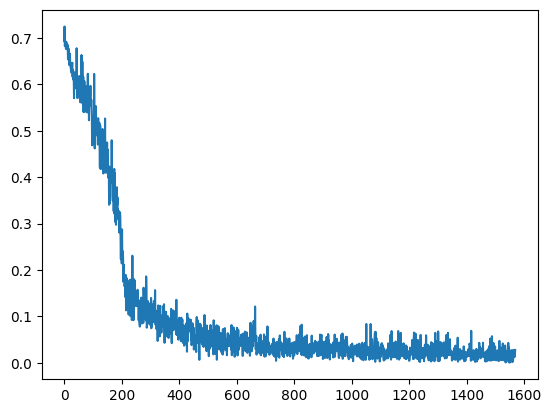

In [42]:
plt.plot(losses)

### Evaluate Training Accuracy

In [43]:
with torch.no_grad():
    correct = 0
    N = 0
    
    for i, (X, y) in enumerate(tqdm(trainloader)):
        probs = lstm(X)
        preds = torch.round(probs)
        
        correct += (preds == y).sum().item()
        N += y.shape[0]
        
    print("Train Accuracy: ", correct/N)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:12<00:00, 12.33it/s]

Train Accuracy:  0.9934
